In [1]:
import os
import numpy as np
import random as python_random
SEED=56789
np.random.seed(SEED)
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Avalon import pyAvalonTools

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from math import sqrt

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Versions of all libraries used
import sys
print("Python version:", sys.version)
print("="*50)

# Core libraries
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

# Machine learning libraries
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")
import scipy
print(f"SciPy version: {scipy.__version__}")

# Cheminformatics
try:
    import rdkit
    print(f"RDKit version: {rdkit.__version__}")
except AttributeError:
    # Some RDKit versions don't have __version__
    from rdkit import rdBase
    print(f"RDKit version: {rdBase.rdkitVersion}")

# Environment information
print("="*50)
print(f"Operating System: {os.name}")
if hasattr(os, 'uname'):
    uname = os.uname()
    print(f"System: {uname.sysname} {uname.release}")
    print(f"Machine: {uname.machine}")

print(f"Random seed used: {SEED}")
print("="*50)

Python version: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
NumPy version: 1.18.1
Pandas version: 1.0.3
Matplotlib version: 3.1.3
Scikit-learn version: 0.21.3
SciPy version: 1.4.1
RDKit version: 2020.03.3
Operating System: posix
System: Linux 5.15.0-139-generic
Machine: x86_64
Random seed used: 56789


In [3]:
# Read the train and test sets
train_df_loaded = pd.read_csv('RET_Mutant_train_set.csv')
test_df_loaded = pd.read_csv('RET_Mutant_test_set.csv')

# Extract SMILES and targets from the loaded dataframes
X_train = train_df_loaded['RDKIT_SMILES']
Y_train = train_df_loaded['pIC50']
X_test = test_df_loaded['RDKIT_SMILES']
Y_test = test_df_loaded['pIC50']

print(f"Loaded train set: {len(X_train)} samples")
print(f"Loaded test set: {len(X_test)} samples")
print(f"Train target range: {Y_train.min():.3f} - {Y_train.max():.3f}")
print(f"Test target range: {Y_test.min():.3f} - {Y_test.max():.3f}")

Loaded train set: 696 samples
Loaded test set: 174 samples
Train target range: 5.000 - 8.046
Test target range: 5.000 - 7.836


In [4]:
def smiles_to_mols(query_smiles):
    mols = [Chem.MolFromSmiles(smile) for smile in query_smiles]
    valid = [0 if mol is None else 1 for mol in mols]
    valid_idxs = [idx for idx, boolean in enumerate(valid) if boolean == 1]
    valid_mols = [mols[idx] for idx in valid_idxs]
    return valid_mols, valid_idxs

class Descriptors:

    def __init__(self, data):
        self._data = data

    def ECFP(self, radius, nBits):
        fingerprints = []
        mols, idx = smiles_to_mols(self._data)
        fp_bits = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in mols]
        for fp in fp_bits:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, idx

    def ECFP_counts(self, radius, useFeatures, useCounts=True):
        mols, valid_idx = smiles_to_mols(self._data)
        fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in mols]
        size = 2048
        nfp = np.zeros((len(fps), size), np.int32)
        for i, fp in enumerate(fps):
            for idx, v in fp.GetNonzeroElements().items():
                nidx = idx % size
                nfp[i, nidx] += int(v)
        return nfp, valid_idx

    def Avalon(self, nBits):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [pyAvalonTools.GetAvalonFP(mol, nBits=nBits) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, nBits), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

    def MACCS_keys(self):
        mols, valid_idx = smiles_to_mols(self._data)
        fingerprints = []
        fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
        for fp in fps:
            fp_np = np.zeros((1, ), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, fp_np)
            fingerprints.append(fp_np)
        return fingerprints, valid_idx

def get_ECFP6_counts(inp):
    if not isinstance(inp, list):
        inp = list(inp)
    desc = Descriptors(inp)
    fps, _ = desc.ECFP_counts(radius=3, useFeatures=True, useCounts=True)
    return fps

In [5]:
train_fps = get_ECFP6_counts(X_train)
test_fps = get_ECFP6_counts(X_test)

In [6]:
models_RF_train = {"RF": RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)}

In [7]:
# Calculate the Training statistics
scores = {}
for m in models_RF_train:
    models_RF_train[m].fit(train_fps, Y_train)
    scores[m + "_train_r2"] = models_RF_train[m].score(train_fps, Y_train)
    Y_pred_train_rf = models_RF_train[m].predict(train_fps)
    scores[m + "_rmse_train"] = sqrt(mean_squared_error(Y_train, Y_pred_train_rf))
    scores[m + "_mae_train"] = mean_absolute_error(Y_train, Y_pred_train_rf)
    scores[m + "_pcc_train"] = pearsonr(Y_train, Y_pred_train_rf)
scores_RF_train = pd.Series(scores).T
scores_RF_train

RF_train_r2                        0.92933
RF_rmse_train                     0.168868
RF_mae_train                      0.128149
RF_pcc_train     (0.9732395208969024, 0.0)
dtype: object

In [8]:
# Calculate statistics for test set based on RF model
scores = {}
for m in models_RF_train:
    Y_pred_test_rf = models_RF_train[m].predict(test_fps)
    scores[m + "_test_r2"] = r2_score(Y_test, Y_pred_test_rf)
    scores[m + "_rmse_test"] = sqrt(mean_squared_error(Y_test, Y_pred_test_rf))
    scores[m + "_mae_test"] = mean_absolute_error(Y_test, Y_pred_test_rf)
    scores[m + "_pcc_test"] = pearsonr(Y_test, Y_pred_test_rf)
scores_RF_test = pd.Series(scores).T
scores_RF_test

RF_test_r2                                         0.584431
RF_rmse_test                                       0.397593
RF_mae_test                                        0.293664
RF_pcc_test     (0.7691952700354965, 2.776915926013935e-35)
dtype: object

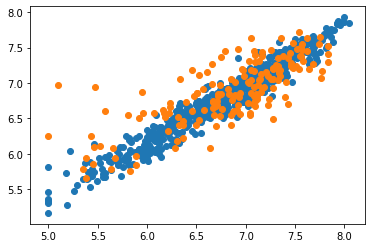

In [9]:
# Scatter plot for Random Forest Model
plt.scatter(Y_train, Y_pred_train_rf)
plt.scatter(Y_test, Y_pred_test_rf)
plt.show()

In [10]:
# Calculate statistics for overall set based on RF model
models_RF_final = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=270,
                      n_jobs=None, oob_score=False, random_state=1234,
                      verbose=0, warm_start=False)

# fit to all data points
complete_fps = np.concatenate((train_fps, test_fps), axis=0)
complete_y = pd.concat((Y_train, Y_test))
models_RF_final.fit(complete_fps, complete_y)
y_pred_final = models_RF_final.predict(complete_fps)
models_RF_final_r2 = r2_score(complete_y, y_pred_final)
print(models_RF_final_r2)

0.9320626723223974


In [11]:
# save the final model
with open(("RET_MUTANT_final_model_Hyper1.pkl"), "wb") as f:
    pickle.dump(models_RF_final, f)